In [4]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import datetime
import pickle

def find_nearest(array, value):
    return (np.abs(array - value)).argmin(axis=1)

# Read and reformat data from FROST
The data can be downloaded using get_weather_station.py

In [6]:
files = os.listdir('./stations')
files.remove('meta_data.pkl') #not a station

In [7]:
stations = []
for id_ in files:
    stations.append(xr.open_dataset("./stations/"+id_))

In [8]:
# string datatype was lost in export, this loop fixes these strings. 
for station in stations:
    station['id'] = station['id'].astype(str)
    station['name'] = station['name'].astype(str)
    station['shortname'] = station['shortname'].astype(str)
    station['latitude'] = float(station['latitude'])
    station['longitude'] = float(station['longitude'])
    station['resolution'] = station['resolution'].astype(str)

# Interpolate and plot map

In [9]:
# get grid from radar image
a_file = open("/home/erlend/radar.pkl", "rb")
output = pickle.load(a_file)
x_grid = output.pop('lon')
y_grid = output.pop('lat')

In [12]:
map_norway = np.zeros(x_grid.shape)
from global_land_mask import globe
for i in range(map_norway.shape[0]):
    for j in range(map_norway.shape[1]):
        map_norway[i, j] = globe.is_land(y_grid[i, j], x_grid[i, j])

In [ ]:
#import pyresample

# Define lat-lon grid
#lon_grid, lat_grid = np.meshgrid(lon, lat)
#grid = pyresample.geometry.GridDefinition(lats=lat_grid, lons=lon_grid)

# Generate some random data on the grid
#data_grid = np.random.rand(lon_grid.shape[0], lon_grid.shape[1])

# Define some sample points
#my_lons = np.array([34.5, 36.5, 38.5])
#my_lats = np.array([12.0, 14.0, 16.0])
#swath = pyresample.geometry.SwathDefinition(lons=my_lons, lats=my_lats)


### Kriging interpolation

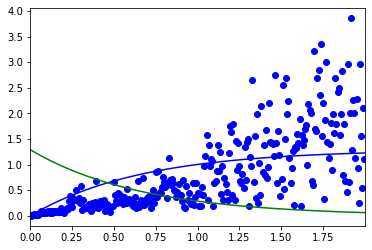

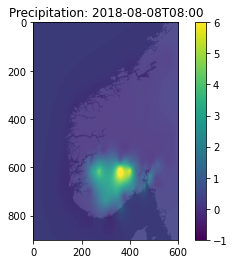

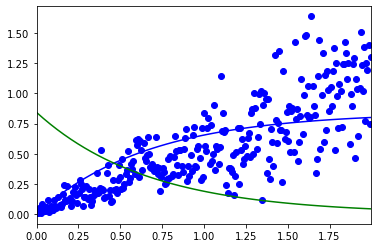

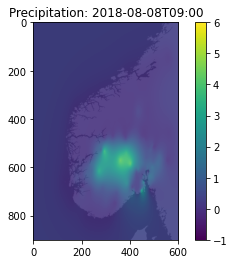

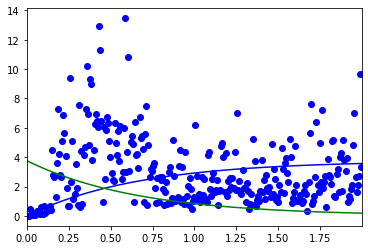

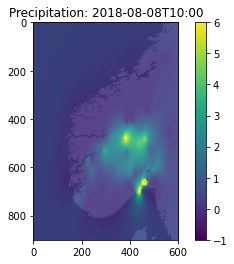

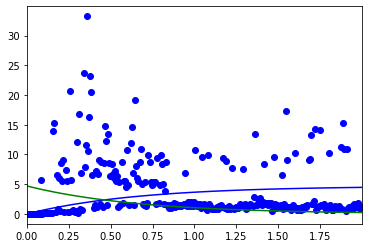

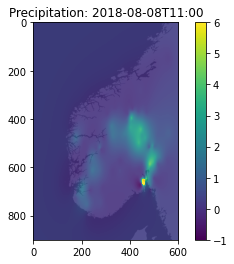

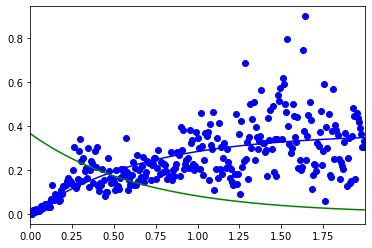

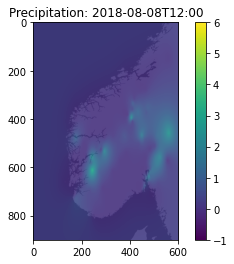

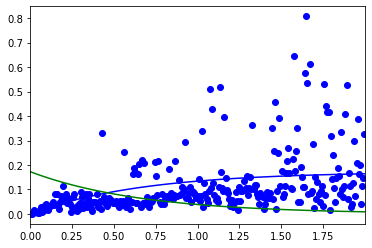

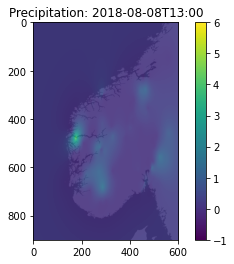

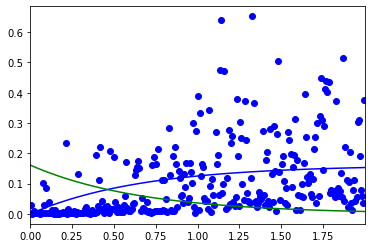

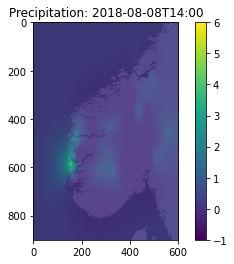

In [18]:
from geostat import OrdinaryKriging # my own module

for t_i in range(len(stations[0]['time'])): # go thru recorded time    
    t = stations[0]['time'][t_i] # first station has all 7 timeintervalls
    
    # search if time value exists in station
    
    x_data = np.array([stat['longitude'] for stat in stations if t.isin(stat.time)])
    y_data = np.array([stat['latitude'] for stat in stations if t.isin(stat.time)])
    p_data = np.array([stat['PT1H'].sel(time = t) for stat in stations if t.isin(stat.time)])
        
    OK = OrdinaryKriging(
        x_data, #x-values
        y_data, #y-values
        p_data, #
        variogram_parameters = [-3, 1, 2, 0], # [alpha, beta, hr, c0]
        enable_plotting=True, 
        n_bins = 300, # number of averaging bins
    )    
    
    z_grid_intp, z_grid_sigma = OK.predict(x_grid, y_grid)
    plt.imshow(z_grid_intp) 
    plt.clim(-1,6)
    plt.colorbar()

    plt.imshow(map_norway, alpha=0.1, cmap='gray')
    
    plt.title("Precipitation: " + np.datetime_as_string(stations[0].time.values[t_i])[0:16])

    # plt.scatter(index_array_2d[0], index_array_2d[1], c='red', marker='o')
    plt.show()
    
    
    #plt.imshow(z_grid_sigma, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
    #       vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    #plt.clim(0,1.5)
    #plt.colorbar()
    #plt.title("Standard deviation: " + np.datetime_as_string(stations[0].time.values[t_i])[0:16])
    #plt.scatter(x_data, y_data, c='red', marker='o')
    #plt.show()

In [17]:
z_grid_intp.min()

-0.06288706727935622

### Verify by pykrige

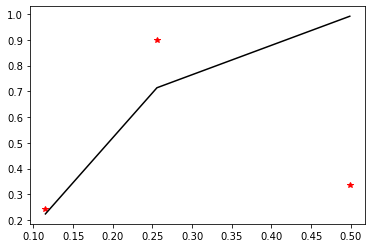

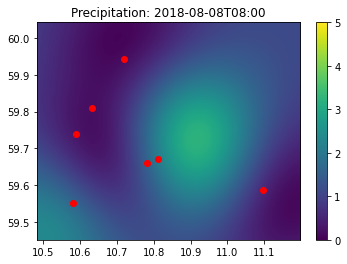

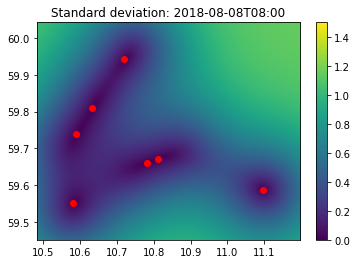

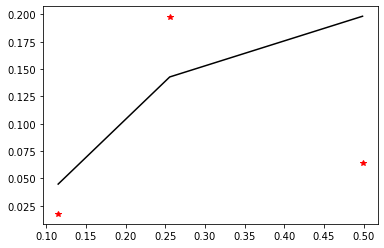

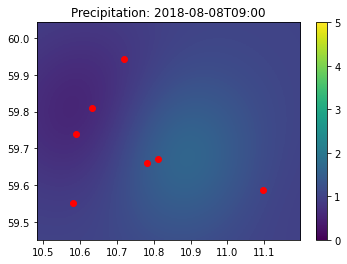

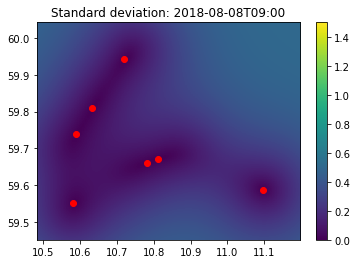

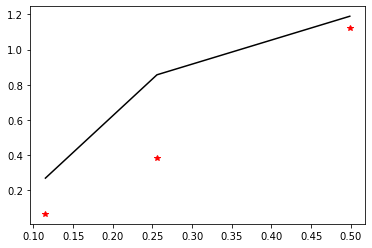

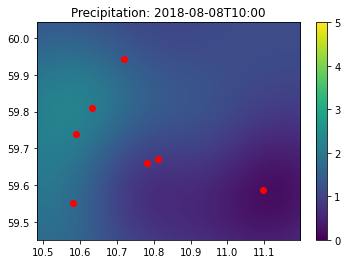

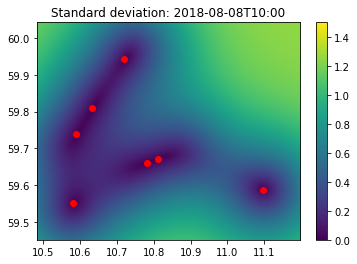

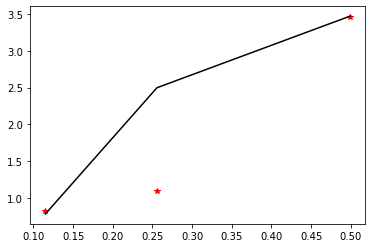

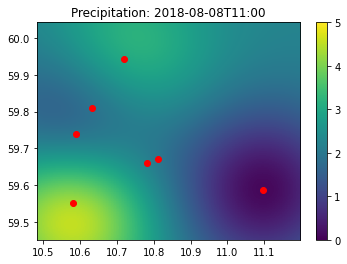

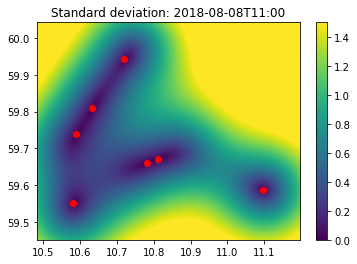

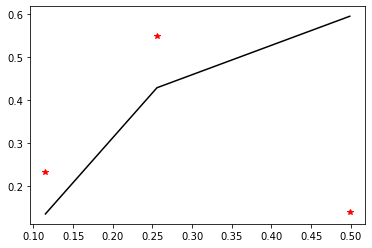

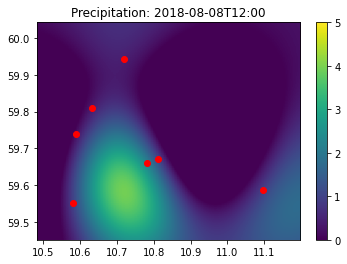

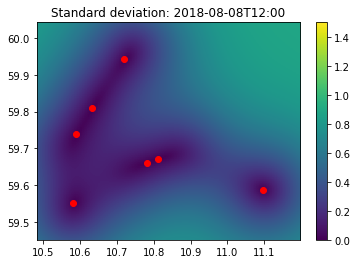

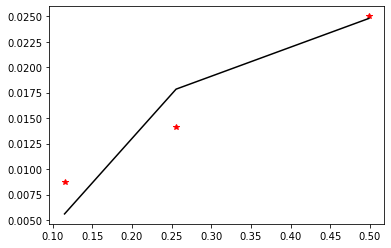

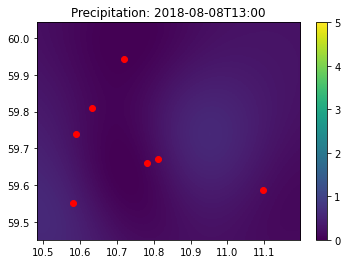

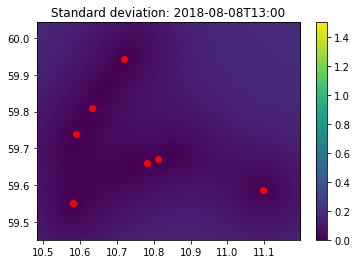

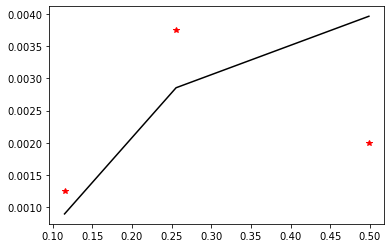

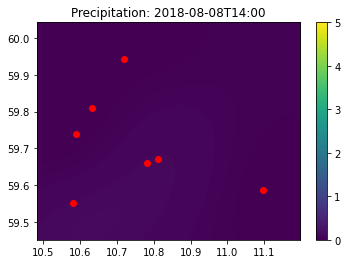

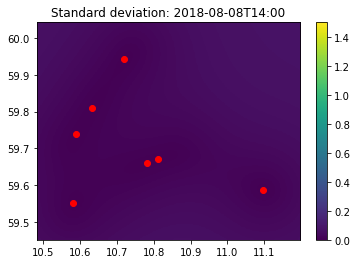

In [29]:
# note: The variogram was found differently, here by 

sill_list = [1.0, 0.2, 1.2, 3.5, 0.6, 0.025, 0.004]

from pykrige.ok import OrdinaryKriging as pykrige
for t_i in range(len(stations[0]['time'])): # time index
    p = p_data[:, t_i]
    OK = pykrige(
        x_data, #x-values
        y_data, #y-values
        p, # precipitation
        variogram_model="gaussian",
        variogram_parameters = {'sill':sill_list[t_i], 'range':0.4, 'nugget':0},
        enable_plotting=True, 
        nlags = 3, #number of averaging bins
        pseudo_inv = True
    )
    
    z_grid_intp, z_grid_sigma = OK.execute("grid", x_grid, y_grid)
    z_grid_sigma = np.sqrt(z_grid_sigma)
    plt.imshow(z_grid_intp, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,5)
    plt.colorbar()
    
    plt.title("Precipitation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()
    
    
    plt.imshow(z_grid_sigma, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,1.5)
    plt.colorbar()
    plt.title("Standard deviation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()

In [73]:
p_data

[<xarray.DataArray 'PT1H' (time: 7)>
 array([0. , 0.2, 0. , 0. , 0. , 0. , 0. ])
 Coordinates:
   * time        (time) datetime64[ns] 2018-08-08T08:00:00 ... 2018-08-08T14:0...
     latitude    float64 59.66
     longitude   float64 5.954
     resolution  <U30 'sum(precipitation_amount PT1H)'
     shortname   <U5 'Etne '
     id          <U7 'SN47498'
     name        <U7 'ETNE II',
 <xarray.DataArray 'PT1H' (time: 7)>
 array([0, 0, 0, 0, 0, 0, 0])
 Coordinates:
   * time        (time) datetime64[ns] 2018-08-08T08:00:00 ... 2018-08-08T14:0...
     latitude    float64 60.34
     longitude   float64 6.218
     resolution  <U30 'sum(precipitation_amount PT1H)'
     shortname   <U8 'Aksneset'
     id          <U7 'SN50110'
     name        <U15 'KVAM - AKSNESET',
 <xarray.DataArray 'PT1H' (time: 7)>
 array([0. , 0. , 0. , 0. , 0. , 0. , 1.4])
 Coordinates:
   * time        (time) datetime64[ns] 2018-08-08T08:00:00 ... 2018-08-08T14:0...
     latitude    float64 60.29
     longitude   float